In [1]:
import gpytorch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from func_data_generation import *
from func_polygon import *
from torch import nn
from torchsummary import summary
from utils import *
from warp_units import *

dtype = torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using cuda device


In [2]:
class ScaleToBounds(torch.nn.Module):
    """
    Scale the input data so that it lies in between the lower and upper bounds.

    In training (`self.train()`), this module adjusts the scaling factor to the minibatch of data.
    During evaluation (`self.eval()`), this module uses the scaling factor from the previous minibatch of data.

    :param float lower_bound: lower bound of scaled data
    :param float upper_bound: upper bound of scaled data

    Example:
        >>> train_x = torch.randn(10, 5)
        >>> module = gpytorch.utils.grid.ScaleToBounds(lower_bound=-1., upper_bound=1.)
        >>>
        >>> module.train()
        >>> scaled_train_x = module(train_x)  # Data should be between -0.95 and 0.95
        >>>
        >>> module.eval()
        >>> test_x = torch.randn(10, 5)
        >>> scaled_test_x = module(test_x)  # Scaling is based on train_x
    """

    def __init__(self, lower_bound, upper_bound):
        super().__init__()
        self.lower_bound = float(lower_bound)
        self.upper_bound = float(upper_bound)
        self.register_buffer("min_val", torch.tensor(lower_bound))
        self.register_buffer("max_val", torch.tensor(upper_bound))

    def forward(self, x):
        if self.training:
            min_val = x.min()
            max_val = x.max()
            self.min_val.data = min_val
            self.max_val.data = max_val
        else:
            min_val = self.min_val
            max_val = self.max_val
            # Clamp extreme values
            x = x.clamp(min_val, max_val)

        diff = max_val - min_val
        x = (x - min_val) * (
            0.95 * (self.upper_bound - self.lower_bound) / diff
        ) + 0.95 * self.lower_bound
        return x

In [3]:
class WarpModel(torch.nn.Sequential):
    def __init__(self):
        super(WarpModel, self).__init__()
        self.add_module(
            "axial_dim0", AxialWarpUnit(dim=0, res=20, grad=20, lims=[0, 1.0])
        )
        self.add_module(
            "axial_dim1", AxialWarpUnit(dim=1, res=20, grad=20, lims=[-1.0, 0])
        )
        #         self.add_module("rbf_seq1", rbfunit_sequential(res=1, ylim=[-1, 0]))
        self.add_module("rbf_seq2", rbfunit_sequential(res=2, ylim=[-1, 0]))

        #         self.add_module("rbf_seq3", rbfunit_sequential(res=3, ylim=[-1, 0]))

        self.add_module("mobius", MobiusWarpUnit())


class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, warp_model):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.space_transform = warp_model
        self.scale_to_bounds = ScaleToBounds(0, 1)

    def forward(self, x):
        # We're first putting our data through a deep net (feature extractor)
        # We're also scaling the features so that they're nice values
        projected_x = self.space_transform(x)
        projected_x = self.scale_to_bounds(projected_x)
        #         projected_x = projected_x - projected_x.min(0)[0]
        #         projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [4]:
# generate a warp model
random_seed = 88
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

warp_model = WarpModel()

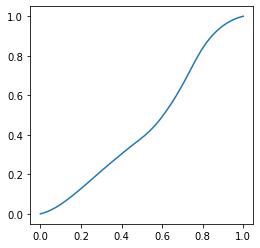

In [5]:
oned_map(warp_model.axial_dim0, dim=0)

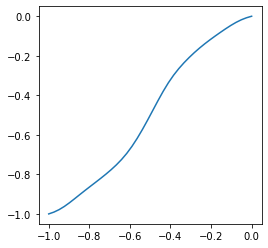

In [6]:
oned_map(warp_model.axial_dim1, dim=1)

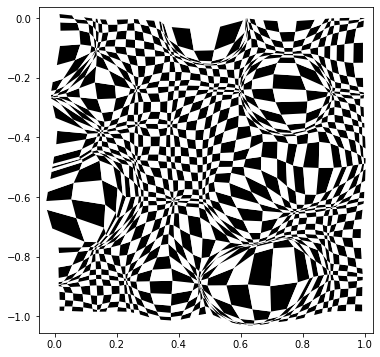

In [7]:
chessboard_from_model(warp_model.rbf_seq2, chessgrid_res=40)

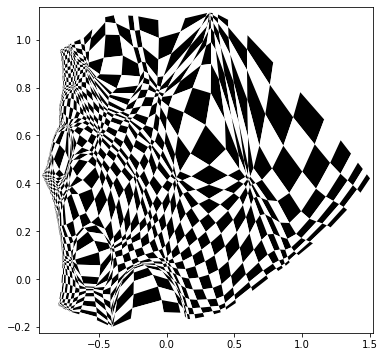

In [8]:
chessboard_from_model(warp_model, chessgrid_res=40)

1000 * 1000 的场地上，生成1000 * 1000个点的数据

In [19]:
# generate gp_model and set the hyperparameter
likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
gp_model = GPRegressionModel(
    train_x=None, train_y=None, likelihood=likelihood, warp_model=warp_model
).to(device)
gp_model.covar_module.base_kernel.lengthscale = torch.tensor(
    [
        [
            0.1,
        ]
    ]
).to(device)
gp_model.covar_module.outputscale = torch.tensor(32.0).to(device)

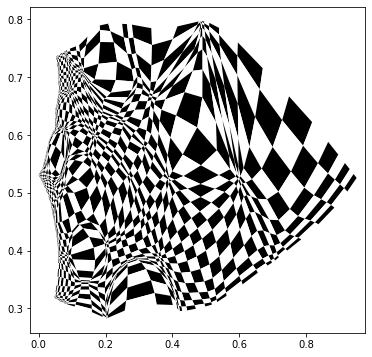

In [20]:
test_model = nn.Sequential().to(device)
test_model.add_module("warp_model", warp_model)
test_model.add_module("scal_model_1", gp_model.scale_to_bounds)
chessboard_from_model(test_model, chessgrid_res=40)

In [2]:
data_sets = data_generation(gp_model, likelihood, grid_res=180, seed=13)
torch.cuda.empty_cache()

NameError: name 'gp_model' is not defined

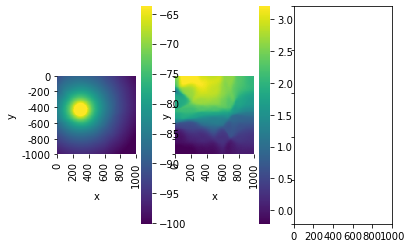

In [27]:
fig, (ax1, ax2, ax_3) = plt.subplots(1, 3, sharex=True, sharey=True)
plot_heatmap(data_sets["coords"], data_sets["true_rss"], ax=ax1, cbar=True, robust=True)
plot_heatmap(data_sets["coords"], data_sets["shadow"], ax=ax2, robust=True, cbar=True)

In [28]:
save_data("datasets_2", data_sets)
add_training_data("datasets_2")

In [9]:
list(range(50, 501, 50))

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

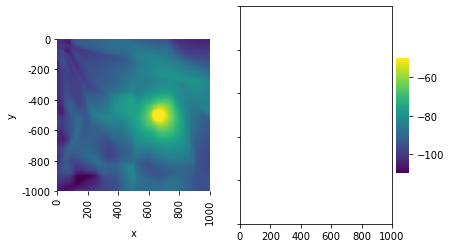

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.91, 0.3, 0.03, 0.4])
plot_heatmap(coords, true_rss, ax=ax1, vmin=-110, vmax=-50, cbar=True, cbar_ax=cbar_ax)
# plot_heatmap(coords, true_rss, mask_idx=idx, ax=ax2)